# **SkyNetAI: Deep Learning for Multi-Source Semantic Segmentation of High-Resolution Aerial Imagery**
# 1. Data description & preparation <a name="1"></a>
## 1.1 Data Visualizations <a name="1.1"></a>

In [1]:
! pip install segmentation-models-pytorch torchviz torchsummary --quiet

In [2]:
# Ignore warnings to avoid unnecessary clutter
import warnings
warnings.filterwarnings("ignore")

# Standard libraries for file handling and system operations
import os
import time
import random
import shutil
from pathlib import Path
import glob

# Data manipulation and scientific libraries
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors  # For custom color maps

# PyTorch and related libraries for model building, training, and evaluation
import torch
from torch import nn
import torchmetrics
from torch.optim import Adam
import torch.nn.functional as F
from torchviz import make_dot # For Plotting Model
from torchsummary import summary  # For model summary
import torchvision.transforms.functional as TF  # For image transforms
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp  # For segmentation models

# Image processing libraries for augmentation and transformations
import cv2
import albumentations as A  # For advanced augmentations

# Set random seed for reproducibility
np.random.seed(42)

# Dataset and directory paths
DATASET_NAME = 'landcoverai'  # Dataset name
OUTPUT_DIR = os.path.join(os.getcwd(), "output")  # Output directory for saving results
IMGS_DIR = f"../input/{DATASET_NAME}/images"  # Path to images
MASKS_DIR = f"../input/{DATASET_NAME}/masks"  # Path to masks
DATA_ROOT = f"../input/{DATASET_NAME}"  # Root directory for dataset
IMG_PATHS = glob.glob(os.path.join(IMGS_DIR, "*.tif"))  # List all image files
MASK_PATHS = glob.glob(os.path.join(MASKS_DIR, "*.tif"))  # List all mask files

# Image and mask processing settings
IMAGE_SIZE = 512  # Image resizing size

# Custom color map for land-use labels (background, building, woodland, water, road)
labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9", "#8B8680", "#D3D3D3", "#FFFFFF"])

# Set device to GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1.2 Image Cropping <a name="1.2"></a>

### 1.2.1 Squared images of size 512 <a name="1.2.1"></a>

In [3]:
def split_images(TARGET_SIZE=IMAGE_SIZE):
    """
    Splits aerial images and masks into tiles of size TARGET_SIZE, saving
    them in the output directory.
    """
    tic = time.time()
    
    if Path(OUTPUT_DIR).exists():
        shutil.rmtree(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR)
    
    for img_path, mask_path in tqdm(zip(IMG_PATHS, MASK_PATHS), total=len(IMG_PATHS), desc="Processing Images"):
        img, mask = cv2.imread(img_path), cv2.imread(mask_path)
        
        for k, (y, x) in enumerate((y, x) for y in range(0, img.shape[0], TARGET_SIZE) for x in range(0, img.shape[1], TARGET_SIZE)):
            img_tile, mask_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE], mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            if img_tile.shape[:2] == (TARGET_SIZE, TARGET_SIZE):
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                cv2.imwrite(f"{OUTPUT_DIR}/{base_name}_{k}.jpg", img_tile)
                cv2.imwrite(f"{OUTPUT_DIR}/{base_name}_{k}_m.png", mask_tile)
    
    mins, sec = divmod(time.time() - tic, 60)
    print(f"Completed in {mins:.0f}m {sec:.2f}s.")

In [4]:
def visualize_dataset(num_samples = 8, w = 10, h = 10, indices = None):
    """
    A function to visualize the images of the dataset along with their
    corresponding masks.
    """
    data_list = list(glob.glob(os.path.join(OUTPUT_DIR, "*.jpg")))
    if indices == None:
        indices = np.random.randint(low = 0, high = len(data_list), size = num_samples)
    fig, ax = plt.subplots(figsize = (h,w), nrows = num_samples//2, ncols = 4)
    for i, idx in enumerate(indices):
        r,rem = divmod(i,2)
        mask = cv2.imread(f"{data_list[indices[i]][:-4]}_m.png")[:, :, 1]
        ax[r,2*rem].imshow(cv2.imread(data_list[idx])/255)
        ax[r,2*rem].set_title("Sample"+str(i+1))
        ax[r,2*rem+1].imshow(mask, cmap = labels_cmap, interpolation = None, vmin = -0.5, vmax = 4.5)
        ax[r,2*rem+1].set_title("Mask" + str(i+1))
    plt.tight_layout(pad = 0.8)
    plt.savefig("viz_dataset.png")
    plt.show()

In [5]:
split_images(TARGET_SIZE = IMAGE_SIZE)

Processing Images: 100%|██████████| 41/41 [01:45<00:00,  2.57s/it]

Completed in 1m 45.39s.


In [6]:
class SegmentationDataset(Dataset):
    """Handles dataset reading, augmentation, and conversion to tensors."""
    def __init__(self, mode="train", ratio=None, transforms=None, seed=42):
        if mode not in {"train", "test", "val"}:
            raise ValueError(f"Mode must be 'train', 'val', or 'test', not '{mode}'.")
        
        self.mode, self.transforms, self.output_dir = mode, transforms, OUTPUT_DIR
        with open(os.path.join(DATA_ROOT, f"{mode}.txt")) as f:
            self.img_names = f.read().splitlines()
        
        if ratio:
            print(f"Using {100*ratio:.2f}% of {mode} set --> {int(ratio * len(self.img_names))}/{len(self.img_names)}")
            np.random.seed(seed)
            self.indices = np.random.choice(len(self.img_names), int(ratio * len(self.img_names)), replace=False)
        else:
            print(f"Using the whole {mode} set --> {len(self.img_names)}")
            self.indices = range(len(self.img_names))

    def __getitem__(self, item):
        img_name = os.path.join(self.output_dir, f"{self.img_names[self.indices[item]]}")
        img = cv2.imread(f"{img_name}.jpg")
        mask = cv2.imread(f"{img_name}_m.png")[:, :, 1]  # Extract green channel

        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img, mask = transformed["image"], transformed["mask"]

        img = np.transpose(img, (2, 0, 1))  # Convert to CxHxW
        return torch.tensor(img, dtype=torch.float32) / 255, torch.tensor(mask, dtype=torch.int64)

    def __len__(self):
        return len(self.indices)

In [7]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 8,num_workers =2)

class_dist = {
    "background":0, 
    "building":0,
    "woodland":0, 
    "water":0, 
    "road":0
}
label_mapping = {
    0: "background", 
    1: "building",
    2: "woodland", 
    3: "water", 
    4: "road"
}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

Using the whole train set --> 7470


# 2. Training Scheme <a name="2"></a>

In [8]:
class EarlyStopping:
    """Early stopping utility to halt training when validation loss does not improve after a set patience period."""

    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): Number of epochs to wait for an improvement in validation loss.
                            Training will stop if no improvement is observed for this many epochs. Default is 7.
            verbose (bool): If True, logs a message each time validation loss improves. Default is False.
            delta (float): Minimum change in validation loss to qualify as an improvement. Default is 0.
            checkpoint_path (str): File path to save the best model checkpoint. Default is 'checkpoint.pt'.
            trace_func (function): Function for logging output, e.g., `print` for console logging. Default is print.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.trace_func = trace_func

        # Internal state variables
        self.counter = 0  # Counts the epochs with no improvement
        self.best_score = None  # Tracks the best validation loss score
        self.early_stop = False  # Flag to trigger early stopping
        self.min_val_loss = np.Inf  # Tracks the minimum validation loss encountered

    def __call__(self, val_loss, model):
        """Checks if validation loss has improved and decides whether to stop training early.
        
        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        # Calculate score as the negative of validation loss (lower loss is better)
        score = -val_loss

        # Initialize best_score if this is the first epoch
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        
        # Check if validation loss has improved by at least `delta`
        elif score < self.best_score + self.delta:
            self.counter += 1  # Increment the counter if no improvement
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            # Stop training if counter reaches patience limit
            if self.counter >= self.patience:
                self.early_stop = True
        
        # Reset counter if there is an improvement in validation loss
        else:
            self.best_score = score  # Update best score
            self.save_checkpoint(val_loss, model)  # Save model checkpoint
            self.counter = 0  # Reset counter

    def save_checkpoint(self, val_loss, model):
        """Saves the model when validation loss decreases.
        
        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.min_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        # Save model state to the specified checkpoint path
        torch.save(model.state_dict(), self.checkpoint_path)
        self.min_val_loss = val_loss  # Update minimum validation loss

In [9]:
def train(model, train_loader, val_loader, epochs, lr, loss_fn, regularization=None, reg_lambda=None, patience=None, verbose=False, model_title="Model", save=False):
    """
    Training loop with early stopping and optional regularization for a PyTorch model.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate for optimizer.
        loss_fn (function): Loss function to use.
        regularization (str, optional): Type of regularization ('L1' or 'L2'). Default is None.
        reg_lambda (float, optional): Regularization coefficient. Default is None.
        patience (int, optional): Number of epochs to wait for improvement before early stopping. Default is None.
        verbose (bool, optional): If True, displays messages for each validation loss improvement. Default is False.
        model_title (str, optional): Title for the model, used in plot titles. Default is "Model".
        save (bool, optional): If True, saves the model's performance plot. Default is False.
    """
    
    print(f"Training of {model_title} starts!")
    start_time = time.time()
    
    # Lists to store loss values for plotting later
    train_loss_history, val_loss_history = [], []
    epochs_completed = 0
    
    # Set up optimizer and early stopping
    optimizer = Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # Training loop across specified epochs
    for epoch in range(epochs):
        epochs_completed += 1
        model.train()
        train_loss, val_loss = 0.0, 0.0  # Track epoch loss
        
        # Progress bar for the training loop
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=False) as train_pbar:
            for train_batch in train_pbar:
                # Move data to device and forward pass
                inputs, labels = train_batch[0].to(device), train_batch[1].to(device)
                predictions = model(inputs)
                loss = loss_fn(predictions, labels)
                
                # Apply regularization if specified
                if regularization:
                    reg_term = sum((p.pow(2.0) if regularization == 'L2' else p.abs()).sum() for p in model.parameters())
                    loss += reg_lambda * reg_term
                
                # Backpropagation and optimizer step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update training loss and progress bar
                train_loss += loss.item()
                train_pbar.set_postfix({"Batch Loss": loss.item()})
        
        # Validation loop, evaluating on the validation dataset
        model.eval()
        with torch.no_grad():
            with tqdm(val_loader, desc="Validation", leave=False) as val_pbar:
                for val_batch in val_pbar:
                    inputs, labels = val_batch[0].to(device), val_batch[1].to(device)
                    predictions = model(inputs)
                    batch_loss = loss_fn(predictions, labels).item()
                    val_loss += batch_loss
                    val_pbar.set_postfix({"Batch Loss": batch_loss})

        # Average losses over all batches in the epoch
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        
        print(f"Epoch: {epoch + 1}/{epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        
        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Plot training and validation loss history
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(range(1, epochs_completed + 1), train_loss_history, label='Training Loss', color="red", linewidth=2.5)
    ax.plot(range(1, epochs_completed + 1), val_loss_history, label='Validation Loss', color="blue", linewidth=2.5)
    ax.set_title(model_title, fontsize=15)
    ax.set_ylabel("Loss", fontsize=13)
    ax.set_xlabel("Epochs", fontsize=13)
    plt.legend()
    if save:
        plt.savefig(f"{model_title}.png")
    plt.show()

    # Load the best model checkpoint saved by early stopping
    model.load_state_dict(torch.load("checkpoint.pt"))
    
    # Calculate total training time
    elapsed_mins, elapsed_secs = divmod(time.time() - start_time, 60)
    print(f"\nTraining Completed in {int(elapsed_mins):02d}m {elapsed_secs:.2f}s.")

In [10]:
# Function to print summary excluding layers with no parameters
def summary_with_params(model, input_size):
    # Print the model architecture using torchsummary
    summary_str = summary(model, input_size=input_size)
    
    # Filter out layers with no parameters
    lines = summary_str.split('\n')
    filtered_lines = [line for line in lines if '0' not in line.split()[-2:]]  # Skip layers with no parameters
    
    # Join and print the filtered summary
    print('\n'.join(filtered_lines))

In [11]:
def test_scores(model, test_loader):
    # StatScores for TP, FP, TN, FN and support
    stat_scores = torchmetrics.StatScores(num_classes=5, task="multiclass", average='none').to(device)
    acc = torchmetrics.Accuracy(num_classes=5, average="micro", task="multiclass").to(device)
    jaccard = torchmetrics.JaccardIndex(num_classes=5, task="multiclass").to(device)
    
    model.eval()
    
    # Dictionaries to accumulate class probabilities and sample counts
    class_probs = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    num_samples = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            logits = F.softmax(model(X), dim=1)
            aggr = torch.max(logits, dim=1)
            preds = aggr[1]
            probs = aggr[0]
            
            # Accumulate probabilities and sample counts for each class
            for label in class_probs.keys():
                class_probs[label] += probs[preds == label].sum()
                num_samples[label] += (preds == label).sum().item()

            # Update metrics
            stat_scores.update(preds, y)
            acc.update(preds, y)
            jaccard.update(preds, y)

    # Final calculation for class probabilities, avoiding division by zero
    for label in class_probs.keys():
        if num_samples[label] > 0:
            class_probs[label] /= num_samples[label]
        else:
            class_probs[label] = 0  # or another suitable default value

    # Extract TP, FP, TN, FN, and support for each class from stat_scores
    stat_scores_results = stat_scores.compute()  # Shape: [num_classes, 5] -> [TP, FP, TN, FN, Support] for each class
    stat_scores_dict = {}
    for i in range(5):  # Assuming 5 classes
        stat_scores_dict[i] = {
            "true_positive": stat_scores_results[i, 0].item(),
            "false_positive": stat_scores_results[i, 1].item(),
            "true_negative": stat_scores_results[i, 2].item(),
            "false_negative": stat_scores_results[i, 3].item(),
            "support": stat_scores_results[i, 4].item()
        }

    return stat_scores_dict, acc.compute(), jaccard.compute(), class_probs

In [12]:
def evaluation_report(classes, scores, acc, jaccard, class_probs):
    print(f" {'Class':<20}{'Precision':<15}{'Recall':<15}{'F1-score':<15}{'Support'}\n")

    # Converting tensors to floats for printing
    acc = float(acc.cpu())
    jaccard = float(jaccard.cpu())

    # Iterate over each class and calculate metrics
    for i, target in enumerate(classes):
        true_positive = scores[i]["true_positive"]
        false_positive = scores[i]["false_positive"]
        false_negative = scores[i]["false_negative"]
        support = scores[i]["support"]

        # Precision, Recall, F1 calculations
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        print(f"* {target:<20}{precision:<15.2f}{recall:<15.2f}{f1:<15.2f}{support}")

    # Print overall accuracy and Jaccard score
    print(f"\n- Total accuracy: {acc:.4f}")
    print(f"- Mean IoU (Jaccard Index): {jaccard:.4f}\n")

    # Print class probabilities
    print("- Class probabilities")
    for idx, prob in class_probs.items():
        print(f"* {classes[idx]:<10}: {float(prob.cpu()):.3f}")

In [13]:
def plot_predictions(model, train_set, title, num_samples = 4, seed = 42, w = 10, h = 10, save_title = None, indices = None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    np.random.seed(seed)
    if indices == None:
        indices = np.random.randint(low = 0, high = len(train_set), size = num_samples)
    fig, ax = plt.subplots(figsize = (w,h), nrows = num_samples, ncols = 3)
    model.eval()
    for i,idx in enumerate(indices):
        X,y = train_set[idx]
        X_dash = X[None,:,:,:].to(device)
        preds = torch.argmax(model(X_dash), dim = 1)
        preds = torch.squeeze(preds).detach().cpu().numpy()
        ax[i,0].imshow(np.transpose(X.cpu(), (2,1,0)))
        ax[i,0].set_title("True Image")
        ax[i,0].axis("off")
        ax[i,1].imshow(y, cmap = labels_cmap, interpolation = None, vmin = -0.5, vmax = 4.5)
        ax[i,1].set_title("Labels")
        ax[i,1].axis("off")
        ax[i,2].imshow(preds, cmap = labels_cmap, interpolation = None, vmin = -0.5, vmax = 4.5)
        ax[i,2].set_title("Predictions")
        ax[i,2].axis("off")
    fig.suptitle(title, fontsize = 20)
    plt.tight_layout()
    if save_title is not None:
        plt.savefig(save_title + ".png")
    plt.show()

## 2.1 Setting the training scheme <a name="3.1"></a>

In [14]:
# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([A.HueSaturationValue(40,40,30,p=1),
             A.RandomBrightnessContrast(p=1,brightness_limit = 0.2, contrast_limit = 0.5)], p = 0.5),
    A.OneOf([A.RandomRotate90(p=1),
             A.HorizontalFlip(p=1),
             A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)], p = 0.5)])

target_names = np.array(["background", "building", "woodland", "water", "road"])

# Hyperparameters
num_classes = len(target_names)
batch_size = 8
epochs = 30
pat = 3
lr = 5e-5


# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass", classes = num_classes).to(device)

# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = transforms, ratio = 0.6)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.7)

train_dloader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

Using 60.00% of train set --> 4482/7470
Using the whole test set --> 1602
Using 70.00% of val set --> 1121/1602


# 3. U-Net with ResNet-50 Encoder <a name="3.3"></a>

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 300MB/s]


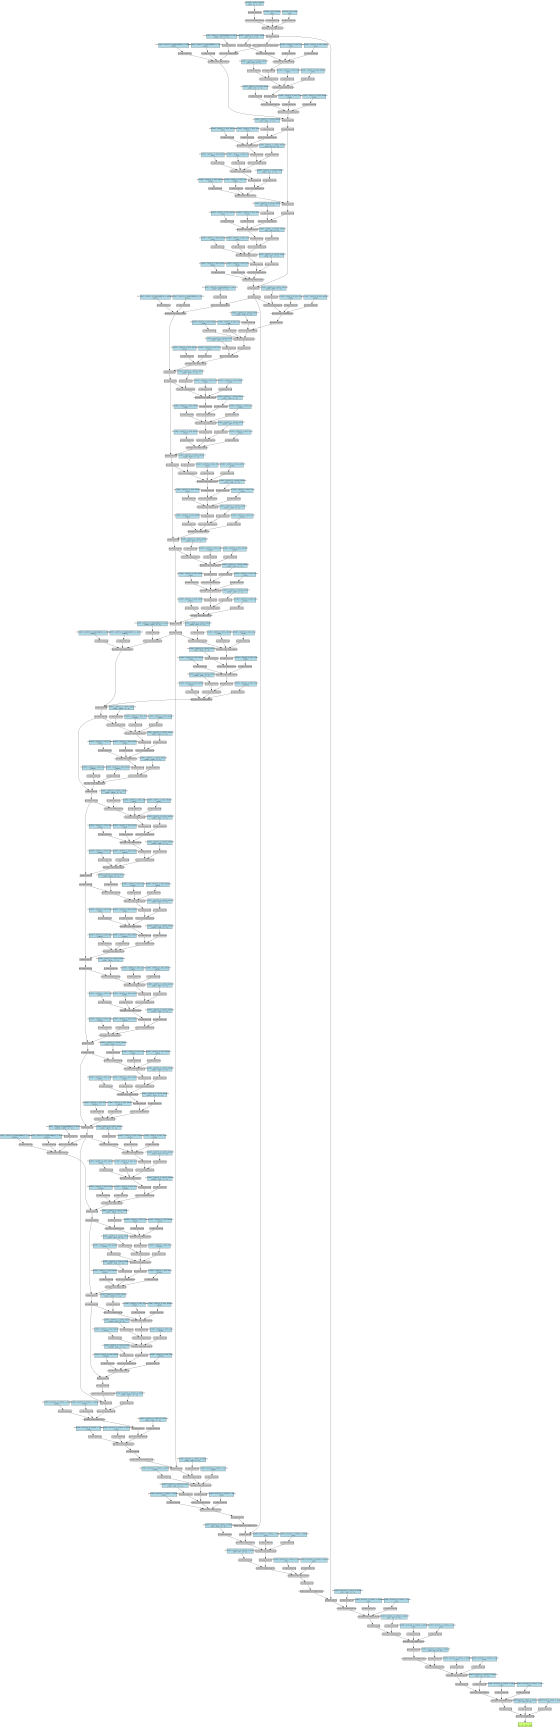

In [15]:
model = smp.Unet(encoder_name = "resnet50",
                 encoder_weights = "imagenet",
                 classes = 5).to(device)
# Generate sample output for the model
output = model(torch.randn(1, 3, 64, 64).to(device))

# Visualize the computational graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.graph_attr.update(size="32,24")
dot.render("smp_unet_computation_graph", format='png')
dot

Training of U-Net with ResNet 50 Encoder starts!


Epoch: 1/30 | Training Loss: 0.6141 | Validation Loss: 0.4350
Validation loss decreased (inf --> 0.435036).  Saving model ...


Epoch: 2/30 | Training Loss: 0.4157 | Validation Loss: 0.3220
Validation loss decreased (0.435036 --> 0.322044).  Saving model ...


Epoch: 3/30 | Training Loss: 0.3455 | Validation Loss: 0.2819
Validation loss decreased (0.322044 --> 0.281866).  Saving model ...


Epoch: 4/30 | Training Loss: 0.3150 | Validation Loss: 0.2675
Validation loss decreased (0.281866 --> 0.267521).  Saving model ...


Epoch: 5/30 | Training Loss: 0.3074 | Validation Loss: 0.2692
EarlyStopping counter: 1 out of 3


Epoch: 6/30 | Training Loss: 0.2891 | Validation Loss: 0.2487
Validation loss decreased (0.267521 --> 0.248741).  Saving model ...


Epoch: 7/30 | Training Loss: 0.2791 | Validation Loss: 0.2437
Validation loss decreased (0.248741 --> 0.243707).  Saving model ...


Epoch: 8/30 | Training Loss: 0.2720 | Validation Loss: 0.2461
EarlyStopping counter: 1 out of 3


Epoch: 9/30 | Training Loss: 0.2598 | Validation Loss: 0.2569
EarlyStopping counter: 2 out of 3


Epoch: 10/30 | Training Loss: 0.2668 | Validation Loss: 0.2390
Validation loss decreased (0.243707 --> 0.238962).  Saving model ...


Epoch: 11/30 | Training Loss: 0.2502 | Validation Loss: 0.2370
Validation loss decreased (0.238962 --> 0.237040).  Saving model ...


Epoch: 12/30 | Training Loss: 0.2483 | Validation Loss: 0.2301
Validation loss decreased (0.237040 --> 0.230136).  Saving model ...


Epoch: 13/30 | Training Loss: 0.2568 | Validation Loss: 0.2362
EarlyStopping counter: 1 out of 3


Epoch: 14/30 | Training Loss: 0.2512 | Validation Loss: 0.2293
Validation loss decreased (0.230136 --> 0.229334).  Saving model ...


Epoch: 15/30 | Training Loss: 0.2436 | Validation Loss: 0.2230
Validation loss decreased (0.229334 --> 0.223029).  Saving model ...


Epoch: 16/30 | Training Loss: 0.2406 | Validation Loss: 0.2300
EarlyStopping counter: 1 out of 3


Epoch: 17/30 | Training Loss: 0.2369 | Validation Loss: 0.2184
Validation loss decreased (0.223029 --> 0.218437).  Saving model ...


Epoch: 18/30 | Training Loss: 0.2320 | Validation Loss: 0.2165
Validation loss decreased (0.218437 --> 0.216529).  Saving model ...


Epoch: 19/30 | Training Loss: 0.2343 | Validation Loss: 0.2351
EarlyStopping counter: 1 out of 3


Epoch: 20/30 | Training Loss: 0.2369 | Validation Loss: 0.2128
Validation loss decreased (0.216529 --> 0.212775).  Saving model ...


Epoch: 21/30 | Training Loss: 0.2289 | Validation Loss: 0.2142
EarlyStopping counter: 1 out of 3


Epoch: 22/30 | Training Loss: 0.2277 | Validation Loss: 0.2218
EarlyStopping counter: 2 out of 3


Epoch: 23/30 | Training Loss: 0.2385 | Validation Loss: 0.2239
EarlyStopping counter: 3 out of 3
Early stopping triggered


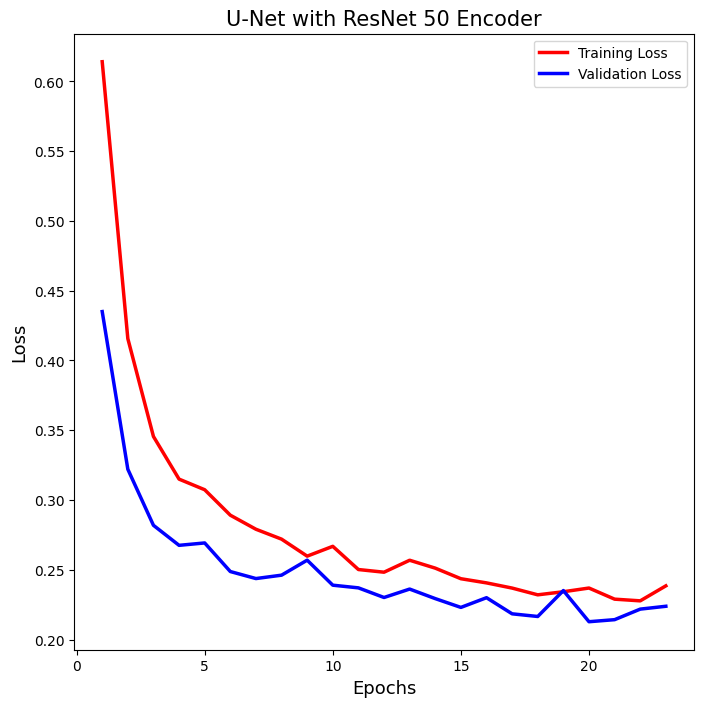


Training Completed in 90m 6.16s.


In [16]:
train(model, train_dloader, val_dloader, epochs, lr, loss_fn, regularization = "L2", reg_lambda = 1e-6, 
      patience = pat, verbose = True, model_title = "U-Net with ResNet 50 Encoder", save = True)
torch.save(model.state_dict(), 'unet_restnext_final.pth')

In [17]:
# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = test_scores(model = model, test_loader = test_dloader)
evaluation_report(target_names, scores, acc, jaccard, class_probs)

 Class               Precision      Recall         F1-score       Support

* background          0.96           0.95           0.96           239926712
* building            0.90           0.83           0.86           3956554
* woodland            0.93           0.96           0.94           144170112
* water               0.97           0.95           0.96           24388122
* road                0.83           0.70           0.76           7513188

- Total accuracy: 0.9478
- Mean IoU (Jaccard Index): 0.8205

- Class probabilities
* background: 0.999
* building  : 0.994
* woodland  : 0.999
* water     : 0.999
* road      : 0.991


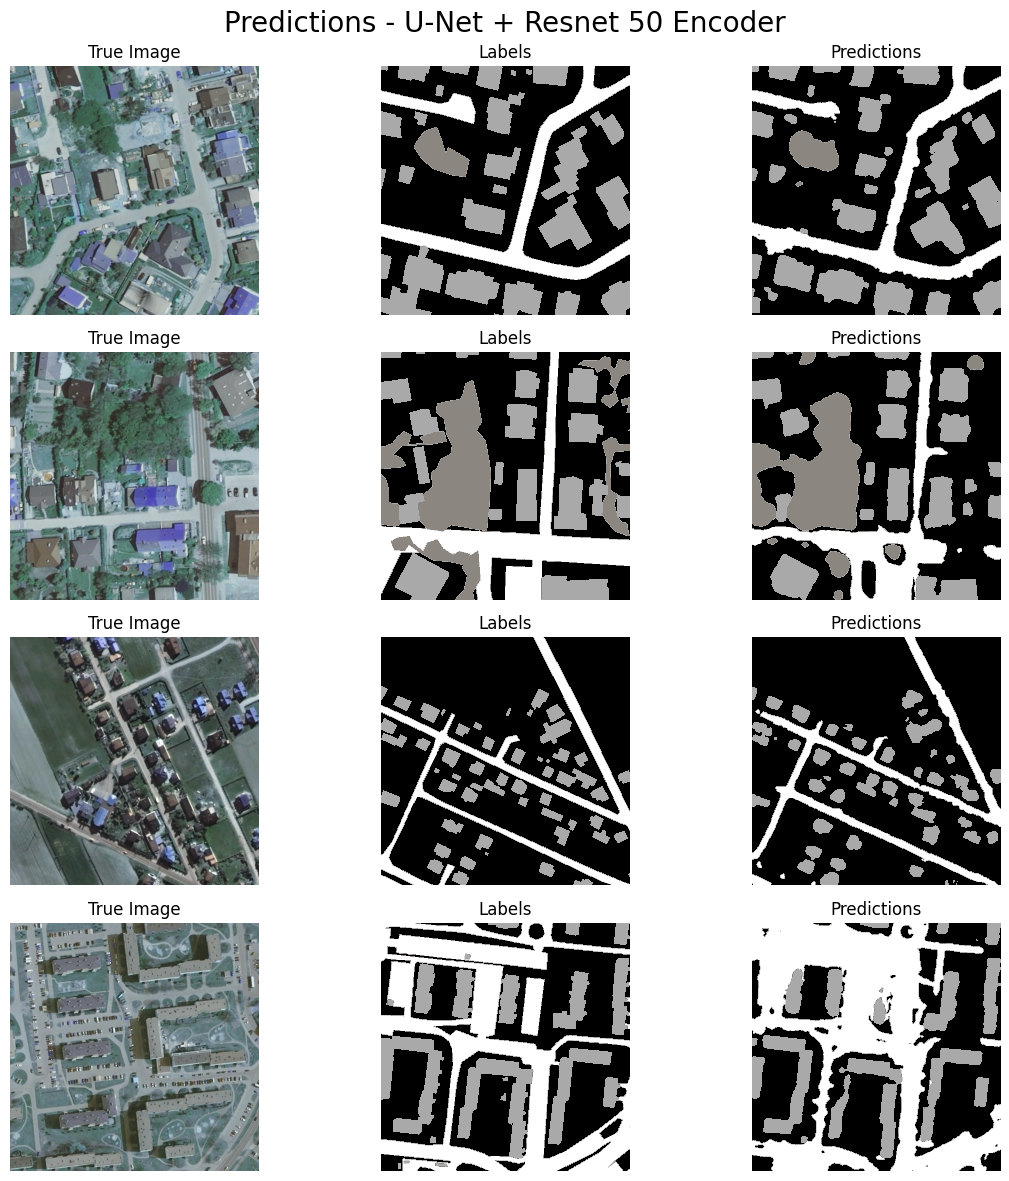

In [18]:
plot_predictions(model, test_set, title = "Predictions - U-Net + Resnet 50 Encoder", save_title = "UNet+Resnet50", h = 12, w = 12, indices = [957,961,1476,1578])